## Installing and Imports libraries

In [1]:
#!pip3 install scikit-image

In [1]:
# Imports
#import random
import numpy as np
import pandas as pd
import os
import sys
#import codecs
#import PIL
#import cv2
#import re
#import string

#import nltk
#from nltk import word_tokenize
#from nltk.stem import WordNetLemmatizer 
#from nltk.corpus import stopwords, wordnet
#from pymorphy2 import MorphAnalyzer

# ML libraries
#from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# keras
import tensorflow as tf
#from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing import sequence
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import efficientnet.tfkeras as efn
#from keras_bert import load_trained_model_from_checkpoint
import albumentations

# plt
#import matplotlib.pyplot as plt

# set not big default graphs
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python         :', sys.version.split('\n')[0])
print('Numpy          :', np.__version__)
print('Tensorflow     :', tf.__version__)
print('Albumentations :', albumentations.__version__)

Python         : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Numpy          : 1.24.2
Tensorflow     : 2.9.1
Albumentations : 1.3.0


In [2]:
# Imports of local libs
sys.path.insert(1, '../')

from utils.paths import create_paths
from utils.read_config import config_reader

from utils.models import MyNaiveModel, SimpleSeqNN, MultiSeqNN, MultiInputNN
from utils.models import define_cat_boost

from utils.nbook_functions import mape_func, create_preproc_data, concat_train_test
from utils.nbook_functions import plot_history_loss, save_best_model, show_sample_imgs
from utils.nbook_functions import get_image_array, show_sample_augmentations

from utils.eda_functions import make_unzip, pre_an_types_feat, prints_types_feat

from utils.keras_functions import callbacks, define_snn_optimizer, data_descr_to_nlp
from utils.keras_functions import define_mnn_optimizer

from utils.preprocess import preproc

In [3]:
# read defined params
config = config_reader('../config/data_config.json')
paths = create_paths(config)

# fix RANDOM_SEED for repeating results
RANDOM_SEED = config.RANDOM_SEED
np.random.seed(RANDOM_SEED)

## Reading Data

In [5]:
# unzip data
is_unzip = False
make_unzip(paths.PATH_TO_ZIP, paths.PATH_DATA, is_unzip=is_unzip)

Zip-archive "sf-dst-car-price-prediction-part2.zip" no need to unpack, to unpack change value of param "is_unzip" to "True"


In [4]:
# Reading '.cvs' data files
train = pd.read_csv(os.path.join(paths.PATH_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(paths.PATH_DATA, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# Let's look at the train data set columns
print(train.columns)

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')


In [5]:
train.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4280,седан,BMW,серый,ID: 38742\n«МБ Измайлово» – официальный диле...,2.0 LTR,136 N12,бензин,241251,2008,3ER,...,539000.0,2011,1099684586,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5975,седан,AUDI,коричневый,Продаю свой авто в связи с крайне редким испол...,1.8 LTR,120 N12,бензин,55000,2011,A4,...,950000.0,2014,1093102394,SEDAN VARIATOR 1.8,вариатор,2 владельца,NaN,Оригинал,передний,Левый


In [6]:
# Comparison of the number of columns in training and test datasets
print(f'Num train cols: {len(train.columns)}, ', f'Num test cols: {len(test.columns)}')
print(f'Col not in test: {set(train.columns) - set(test.columns)}')

# Col with name 'price' - its a target

Num train cols: 22,  Num test cols: 21
Col not in test: {'price'}


In [7]:
# print info about train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [8]:
# Automatic types of test features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(test)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'sell_id', 'vehicleConfiguration', 'Владение']


### Types of features 


<details>
<summary> Display types of all used features </summary> <br>

* bodyType - categorical
* brand - categorical
* color - categorical
* description - text
* engineDisplacement - numeric, represented as text
* enginePower - numeric, represented as text
* fuelType - categorical
* mileage - numeric
* modelDate - numeric or categorical with large num categories
* model_info - categorical
* name - categorical, needs to reduce nums of unique values
* numberOfDoors - categorical
* price - numeric, target
* productionDate - numeric or categorical with large num categories
* sell_id - text, link to images (images are available at the addresses based on sell_id)
* vehicleConfiguration - don't use (cause it's a combination of other columns)
* vehicleTransmission - categorical
* Владельцы - categorical
* Владение - numeric, represented as text
* ПТС - binary
* Привод - categorical
* Руль - binary

Note: Conclusions were done using manual analysis of train and test DataFrames. 
</details>

## Model 1: the "naive" model
This Model 1 will predict the average price by model name and year of manufacture of car.  
We will compare other models with it.

In [ ]:
# splitting of data by train and test
data_train, data_test = train_test_split(train, test_size=0.13, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# predicts of "naive" model
predicts = MyNaiveModel(data_train, data_test).predicts

# evaluating the accuracy (mape metric)
print("The accuracy of the naive model according to the MAPE metric: ",
      f"{(mape_func(data_test['price'], predicts['price'].values))*100:0.2f}%")

The accuracy of the naive model according to the MAPE metric:  18.02%


## Model 2: CatBoostRegressor

In [9]:
# load and prepare data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)

tabular preproc done
data preproc finish


In [10]:
model = define_cat_boost(config)

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=config.cat_verbose_eval,
          use_best_model=True,
          #metric_period
          #plot=True
          )

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape_func(y_test, test_predict_catboost))*100:0.2f}%")

0:	learn: 0.6195124	test: 0.6425148	best: 0.6425148 (0)	total: 194ms	remaining: 5h 23m 29s
100:	learn: 0.2110265	test: 0.2179871	best: 0.2179871 (100)	total: 4.8s	remaining: 1h 19m 3s
200:	learn: 0.1398397	test: 0.1446833	best: 0.1446833 (200)	total: 9.05s	remaining: 1h 14m 53s
300:	learn: 0.1222947	test: 0.1281667	best: 0.1281667 (300)	total: 13s	remaining: 1h 11m 50s
400:	learn: 0.1149996	test: 0.1230560	best: 0.1230560 (400)	total: 16.9s	remaining: 1h 10m 6s
500:	learn: 0.1096957	test: 0.1205843	best: 0.1205790 (491)	total: 20.7s	remaining: 1h 8m 35s
600:	learn: 0.1055974	test: 0.1179773	best: 0.1179761 (599)	total: 24.8s	remaining: 1h 8m 17s
700:	learn: 0.1019847	test: 0.1167754	best: 0.1167754 (700)	total: 28.8s	remaining: 1h 7m 58s
800:	learn: 0.0985935	test: 0.1153604	best: 0.1153604 (800)	total: 32.9s	remaining: 1h 7m 53s
900:	learn: 0.0959542	test: 0.1146799	best: 0.1146799 (900)	total: 36.8s	remaining: 1h 7m 28s
1000:	learn: 0.0935626	test: 0.1140410	best: 0.1140410 (1000)	to

### Creating submission

In [11]:
# creating prediction
sub_predict_catboost = model.predict(X_sub)

# reading sample_submission file
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# creating submission without rounding target
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('../catboost_submission.csv', index=False)

# creating submission with rounding target
sample_submission['price'] = np.round(sub_predict_catboost,-4) # rounding to 4 decimal places
sample_submission.to_csv('../catboost_submission_with_r4.csv', index=False)

## Model 3: Tabular NN

### Simple Dense NN

In [10]:
# load and prepare table data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
config.snn_input_shape = X_train.shape[1]

tabular preproc done
data preproc finish


In [11]:
model = SimpleSeqNN(config).build_model()

optimizer = define_snn_optimizer(config)
model.compile(loss=config.snn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.snn_metric_compile])

callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.snn_batch_size,
                    epochs=config.snn_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=config.snn_verbose,
                    )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 99.9934 - MAPE: 99.9934
Epoch 1: val_MAPE improved from inf to 99.98875, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 4s 232ms/step - loss: 99.9934 - MAPE: 99.9934 - val_loss: 99.9888 - val_MAPE: 99.9888 - lr: 0.0100
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 99.1954 - MAPE: 99.1954
Epoch 2: val_MAPE improved from 99.98875 to 98.66371, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3s 212ms/step - loss: 99.1954 - MAPE: 99.1954 - val_loss: 98.6637 - val_MAPE: 98.6637 - lr: 0.0100
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 89.6355 - MAPE: 89.6355
Epoch 3: val_MAPE improved from 98.66371 to 85.68061, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 2s 191ms/step - loss: 89.6355 - MAPE: 89.6355 - val_loss: 85.6806 - val_MAPE: 85.

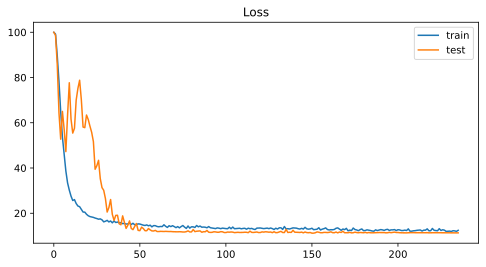

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 0s 9ms/step
TEST mape: 11.19%


In [12]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.snn_best_weights_name,
                config.snn_best_model_name)

# test predict
test_predict_nn3 = model.predict(X_test)
print(f"TEST mape: {(mape_func(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

### Creating submission

In [13]:
# creating prediction
sub_predict_nn3 = model.predict(X_sub)

# reading sample_submission file
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# creating submission without rounding target
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('../nn3_submission.csv', index=False)

# creating submission with rounding target
sample_submission['price'] = np.round(sub_predict_nn3[:,0],-4) # rounding to 4 decimal places
sample_submission.to_csv('../nn3_submission_with_r4.csv', index=False)

53/53 [==============================] - 1s 11ms/step


## Model 4: NLP + Multiple Input

### Load data and Work with data.description

In [5]:
# load and prepare table data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
list_inds = [X_train.index, X_test.index, X_sub.index]
config.msnn_input_shape = X_train.shape[1]

tabular preproc done
data preproc finish


In [6]:
# load and prepare feature 'description' to tokenize
data_descr = concat_train_test(paths).description
data_descr.sample(3)

5194    МБ-Беляево — официальный дилер «Мерседес-Бенц»...
3724    Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...
4518    Машина в хорошем состоянии. Сел и поехал. Влож...
Name: description, dtype: object

In [7]:
# tokenize feature 'description'
text_train_sequences, text_test_sequences, \
    text_sub_sequences, tokenize = data_descr_to_nlp(data_descr, config, list_inds)
# text before and after preparing
print(data_descr.iloc[0], end='\n\n')
print(text_train_sequences[0])

Всем привет!

Продам эксклюзивный проект 124 универсал 300TE-24 SportLine

Модель 124.091 300 TE-24
Двигатель 104.980
Трансмиссия 722.359
Цвет кузова 040 (черный)
Отделка салона 271 (Кожа черная / "антрацит")

Опции:
211 Автоматическая блокировка дифференциала (ASD)
240 Индикатор внешней температуры
244 Спортивные сиденья спереди
281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП
291 Подушка безопасности для водителя и переднего пассажира
300 Дополнительный бардачок в вещевом отсеке спереди
412 Люк с электроприводом и устройством подъёма
420 Автоматическая коробка передач, напольное исполнение
440 Темпомат (круиз-контроль)
538 Автоматическая антенна
541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)
570 Складной подлокотник спереди
586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей
598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)
650 Спортивная подвеска
673 АКБ уве

### Step 1: Creating MultiInputNN model (NLP+SimpleNN with one head) and 
### fit with LR=0.01

In [8]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.msnn_lr_step_1)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# define LR for callbacks function
config.LR = config.msnn_lr_step_1

# define callbacks list with LR
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 99.2528 - MAPE: 99.2528  
Epoch 1: val_MAPE improved from inf to 97.96981, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3876s 322s/step - loss: 99.2528 - MAPE: 99.2528 - val_loss: 97.9698 - val_MAPE: 97.9698 - lr: 0.0100
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 81.5054 - MAPE: 81.5054  
Epoch 2: val_MAPE improved from 97.96981 to 65.29369, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 4186s 351s/step - loss: 81.5054 - MAPE: 81.5054 - val_loss: 65.2937 - val_MAPE: 65.2937 - lr: 0.0100
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 52.8907 - MAPE: 52.8907  
Epoch 3: val_MAPE improved from 65.29369 to 49.69584, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3731s 308s/step - loss: 52.8907 - MAPE: 52.8907 - val_loss: 49.6958 - val_MAP

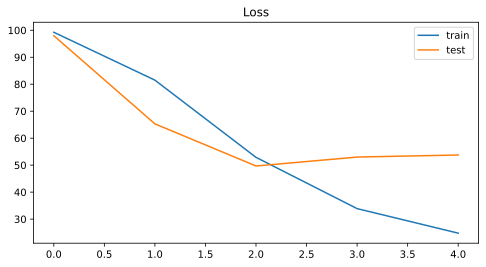

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 217s 8s/step
TEST mape: 49.70%


In [9]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_1,
                config.msnn_best_model_name_st_1)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 2: reduce LR from 0.01 to 0.005 and fit

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 36.0119 - MAPE: 36.0119  
Epoch 1: val_MAPE improved from inf to 44.35678, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3848s 317s/step - loss: 36.0119 - MAPE: 36.0119 - val_loss: 44.3568 - val_MAPE: 44.3568 - lr: 0.0050
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 27.9801 - MAPE: 27.9801  
Epoch 2: val_MAPE did not improve from 44.35678
12/12 [==============================] - 3780s 315s/step - loss: 27.9801 - MAPE: 27.9801 - val_loss: 47.3326 - val_MAPE: 47.3326 - lr: 0.0050
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 23.7398 - MAPE: 23.7398  
Epoch 3: val_MAPE did not improve from 44.35678
12/12 [==============================] - 3612s 300s/step - loss: 23.7398 - MAPE: 23.7398 - val_loss: 49.0656 - val_MAPE: 49.0656 - lr: 0.0050
Epoch 4/5
12/12 [==============================] - ETA: 0s - loss: 21.2719 - MAPE: 21.2719  
Epo

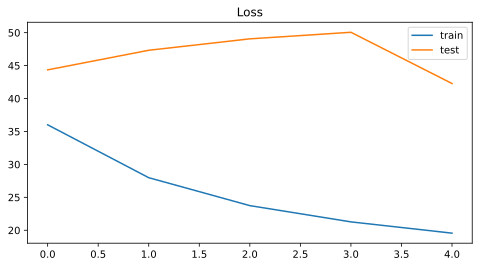

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 193s 7s/step
TEST mape: 42.28%


In [10]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.msnn_lr_step_2)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# loading weights from step 1
model.load_weights(os.path.join(paths.PATH_MODELS, config.msnn_best_weights_name_st_1))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.msnn_lr_step_2)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 2
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_2,
                config.msnn_best_model_name_st_2)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 3: reduce LR from 0.005 to 0.002 and fit

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.msnn_lr_step_3)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# loading weights from step 2
model.load_weights(os.path.join(paths.PATH_MODELS, config.msnn_best_weights_name_st_2))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.msnn_lr_step_3)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 3
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_3,
                config.msnn_best_model_name_st_3)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 4: reduce LR from 0.002 to 0.0002 and fit

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.msnn_lr_step_4)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# loading weights from step 3
model.load_weights(os.path.join(paths.PATH_MODELS, config.msnn_best_weights_name_st_3))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.msnn_lr_step_4)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 4
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_4,
                config.msnn_best_model_name_st_4)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 5: reduce LR from 0.0002 to 0.0001 and fit

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.msnn_lr_step_5)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# loading weights from step 4
model.load_weights(os.path.join(paths.PATH_MODELS, config.msnn_best_weights_name_st_4))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.msnn_lr_step_5)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 5
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_5,
                config.msnn_best_model_name_st_5)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 6: reduce LR from 0.0001 to 0.0000005 and fit

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.msnn_lr_step_6)

# compile model
model.compile(loss=config.msnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.msnn_metric_compile])

# loading weights from step 5
model.load_weights(os.path.join(paths.PATH_MODELS, config.msnn_best_weights_name_st_5))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.msnn_lr_step_6)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.msnn_batch_size,
                    epochs=config.msnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.msnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 6
save_best_model(model, paths,
                config.best_weights_name,
                config.msnn_best_weights_name_st_6,
                config.msnn_best_model_name_st_6)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Step 7: reduce LR from 0.0000005 to 0.00000005 and fit

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_7)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# loading weights from step 6
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_6))

# reduce lr in LR param of config for callbacks functions
config.LR = float(config.mnn_lr_step_7)

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 7
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_7,
                config.mnn_best_model_name_st_7)

# test predict
test_predict_nn4 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

### Creating submission after step 7 with rounding predictions

In [ ]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_7)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# loading weights from step 7
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_7))

# creating prediction
sub_predict_nn4 = model.predict([text_sub_sequences, X_sub])

# reading sample_submission file
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# creating submission without rounding target
sample_submission['price'] = sub_predict_nn4[:,0]
sample_submission.to_csv('../nn4_submission.csv', index=False)

# creating submission with rounding target
sample_submission['price'] = np.round(sub_predict_nn4[:,0],-4) # rounding to 4 decimal places
sample_submission.to_csv('../nn4_submission_with_r4.csv', index=False)

## Model 5: Add picture

### Reading data and analyze images

In [4]:
# load and prepare data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
list_inds = [X_train.index, X_test.index, X_sub.index]
config.minn_tab_input_shape = X_train.shape[1]

# load and prepare feature 'description' to tokenize
data_descr = concat_train_test(paths).description
data = concat_train_test(paths)

# tokenize feature 'description'
text_train_sequences, text_test_sequences, \
    text_sub_sequences, tokenize = data_descr_to_nlp(data_descr, config, list_inds)

tabular preproc done
data preproc finish


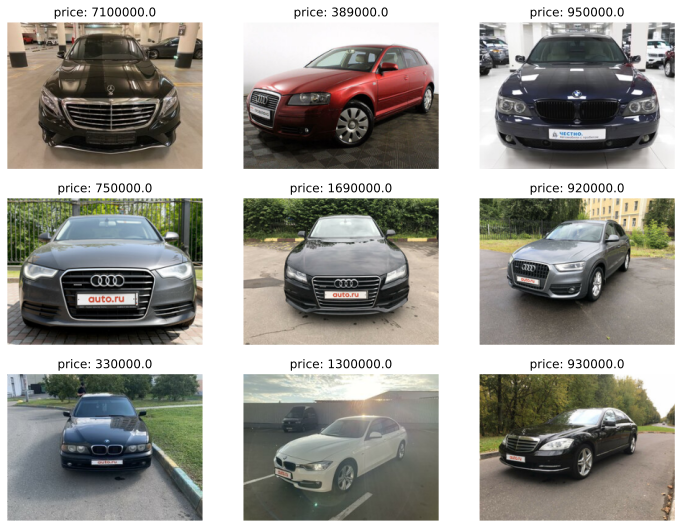

In [5]:
# looking for samples images and target (price)
show_sample_imgs(paths, n_samples=9)

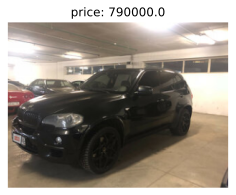

(320, 240)


In [6]:
# one sample image and it's size to understand how better to prepare and zip images
show_sample_imgs(paths, n_samples=1)

In [7]:
# add description
images_train = get_image_array(X_train.index, paths, config)
images_test = get_image_array(X_test.index, paths, config)
images_sub = get_image_array(X_sub.index, paths, config)

images shape (5812, 240, 320, 3) dtype uint8
images shape (869, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [8]:
# define augmentations
augmentation = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    #albumentations.ElasticTransform(p=0.25, alpha=1.0, sigma=10, alpha_affine=10, 
    #                                interpolation=1, border_mode=1, value=(0, 0, 0), 
    #                                mask_value=None, approximate=False),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.GaussNoise(p=0.25, var_limit=(10.0, 500.0), mean=-10),
    #albumentations.GridDistortion(p=0.25, num_steps=15, distort_limit=(-0.3, 0.3), 
    #                              interpolation=3, border_mode=1, value=(0, 0, 0), 
    #                              mask_value=None),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), 
                                      sat_shift_limit=(-20, 20), val_shift_limit=(-20, 20)),
    #albumentations.ISONoise(p=0.5, intensity=(0.1, 0.4), color_shift=(0.01, 0.3)),
    albumentations.MotionBlur(p=0.25, blur_limit=(3, 7)),
    #albumentations.OpticalDistortion(p=0.25, distort_limit=(-0.3, 0.3), 
    #                                 shift_limit=(-0.2, 0.2), interpolation=2, 
    #                                 border_mode=1, value=(0, 0, 0), mask_value=None),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        ],p=0.5),
    albumentations.RandomGamma(p=0.25, gamma_limit=(100, 130), eps=1e-07),
    #albumentations.RandomSnow(p=0.25, snow_point_lower=0.25, snow_point_upper=0.75, 
    #                          brightness_coeff=1.2),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

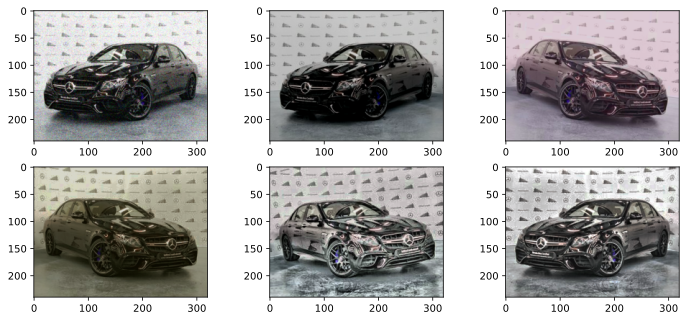

In [9]:
# an example of the use of augmentations
show_sample_augmentations(paths, augmentation)

### Creating preprocessing class and dataset to train model

In [10]:
# add preproc class and dataset to train model
preproc_cls = preproc(config, augmentation, tokenize)

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(preproc_cls.tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(preproc_cls.tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(preproc_cls.tf_process_val_dataset_element)

# checking that there are no errors (no exception will be thrown):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Step 1: Creating MultiInputNN model with images (NLP+SimpleNN+images with one head) and fit with LR=0.01

In [ ]:
# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_1)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])

# change LR for callbacks function
config.LR = float(config.minn_lr_step_1)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with LR
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_1,
                config.minn_best_model_name_st_1)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Step 2: reduce LR from 0.01 to 0.005, unfreeze ~33% last layers of base image model and fit

In [ ]:
# Changing finetune coefficient
config.minn_f_tune_coef = 1.5

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_2)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 1
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_1))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_2)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [6]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_2,
                config.minn_best_model_name_st_2)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Step 3: reduce LR from 0.005 to 0.001, unfreeze ~50% last layers of base image model and fit

In [ ]:
# Changing finetune coefficient
config.minn_f_tune_coef = 2

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_3)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 2
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_2))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_3)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_3,
                config.minn_best_model_name_st_3)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Step 4: reduce LR from 0.001 to 0.0005, unfreeze ~75% last layers of base image model and fit

In [ ]:
# Changing finetune coefficient
config.minn_f_tune_coef = 4

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_4)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 3
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_3))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_4)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_4,
                config.minn_best_model_name_st_4)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Step 5: reduce LR from 0.0005 to 0.0001, unfreeze ~75% last layers of base image model and fit

In [ ]:
# Changing finetune coefficient
config.minn_f_tune_coef = 4

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_5)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 4
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_4))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_5)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_5,
                config.minn_best_model_name_st_5)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Step 6: reduce LR from 0.0001 to 0.00005, unfreeze all layers of base image model and fit

In [ ]:
# Unfreeze to train all layers of base model 
config.minn_train_all_base_layers=True

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_6)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 5
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_5))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_6)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_6,
                config.minn_best_model_name_st_6)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Creating submission after step 6 with and without rounding predictions

In [ ]:
# Unfreeze to train all layers of base model 
config.minn_train_all_base_layers=True

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_6)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 6
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_6))

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 20

# creating prediction
sub_predict_nn5 = model.predict(sub_dataset.batch(config.minn_batch_size))

# reading sample_submission file
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# creating submission without rounding target
sample_submission['price'] = sub_predict_nn5[:,0]
sample_submission.to_csv('../nn5_submission.csv', index=False)

# creating submission with rounding target
sample_submission['price'] = np.round(sub_predict_nn5[:,0],-4) # rounding to 4 decimal places
sample_submission.to_csv('../nn5_submission_with_r4.csv', index=False)

### Step 7: increasing image size + reduce LR from 0.00005 to 0.000001, unfreeze all layers of base image model and fit

In [ ]:
config.img_weight = 448
config.img_height = 336

# add description...
images_train = get_image_array(X_train.index, paths, config)
images_test = get_image_array(X_test.index, paths, config)
images_sub = get_image_array(X_sub.index, paths, config)

In [ ]:
# exclude some tranformations to train model with bigger images
augmentation = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        ],p=0.5),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

In [ ]:
# Unfreeze to train all layers of base model 
config.minn_train_all_base_layers=True

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_7)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 6
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_6))

# change LR for callbacks function
config.LR = float(config.minn_lr_step_7)

# ch default params for callbacks to train model
config.patience_early_stop = 15
config.factor_reduce_plteau = 0.3
config.patience_reduce_plteau = 25

# define callbacks list with changed LR and params
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 10

# fit
history = model.fit(train_dataset.batch(config.minn_batch_size),
                    epochs=config.minn_epochs,
                    validation_data = test_dataset.batch(config.minn_batch_size),
                    callbacks=callbacks_list,
                    verbose=config.minn_verbose
                   )

In [ ]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.minn_best_weights_name_st_7,
                config.minn_best_model_name_st_7)

# test predict
test_predict_nn5 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

### Creating submission after step 7 with and without rounding predictions

In [ ]:
# Unfreeze to train all layers of base model 
config.minn_train_all_base_layers=True

# Creating multiinput neural network
model = MultiInputNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.minn_lr_step_7)

# compile model
model.compile(loss=config.minn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.minn_metric_compile])


# loading weights from step 6
model.load_weights(os.path.join(paths.PATH_MODELS, 
                                config.minn_best_weights_name_st_7))

# change batch_size for train model cause layers be unfreezed
config.minn_batch_size = 10

# creating prediction
sub_predict_nn5 = model.predict(sub_dataset.batch(config.minn_batch_size))

# creating submission without rounding target
sample_submission['price'] = sub_predict_nn5[:,0]
sample_submission.to_csv('../nn5_submission_st7.csv', index=False)

# creating submission with rounding target
sample_submission['price'] = np.round(sub_predict_nn5[:,0],-4) # rounding to 4 decimal places
sample_submission.to_csv('../nn5_submission_with_r4_st7.csv', index=False)

## Blending submissions from models

In [ ]:
# reading submissions from 4 models without rounding results
sub_predict_catboost = np.array(pd.read_csv('../catboost_submission.csv')['price'])
sub_predict_nn3 = np.array(pd.read_csv('../nn3_submission.csv')['price'])
sub_predict_nn4 = np.array(pd.read_csv('../nn4_submission.csv')['price'])
sub_predict_nn5 = np.array(pd.read_csv('../nn5_submission_st7.csv')['price'])

# blending submissions without rounding results
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3 + sub_predict_nn4 + sub_predict_nn5)/4
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_4_models.csv', index=False)

# blending submissions without rounding results from 3 models (without catboosting)
blend_sub_predict_w_out_cat = (sub_predict_nn3 + sub_predict_nn4 + sub_predict_nn5)/3
sample_submission['price'] = blend_sub_predict_w_out_cat
sample_submission.to_csv('blend_submission_3nn_models.csv', index=False)

In [ ]:
# reading submissions from 4 models with rounding results np.round(predictions, -4)
sub_predict_catboost_r4 = np.array(pd.read_csv('../catboost_submission_with_r4.csv')['price'])
sub_predict_nn3_r4 = np.array(pd.read_csv('../nn3_submission_with_r4.csv')['price'])
sub_predict_nn4_r4 = np.array(pd.read_csv('../nn4_submission_with_r4.csv')['price'])
sub_predict_nn5_r4 = np.array(pd.read_csv('../nn5_submission_with_r4_st7.csv')['price'])

# blending submissions with rounding results from 4 models
blend_sub_predict_rounded = (sub_predict_catboost_r4 + sub_predict_nn3_r4 + sub_predict_nn4_r4 + sub_predict_nn5_r4)/4
sample_submission['price'] = blend_sub_predict_rounded
sample_submission.to_csv('blend_submission_4_models_r4.csv', index=False)

# blending submissions with rounding results from 3 models (without catboosting)
blend_sub_predict_w_out_cat_r4 = (sub_predict_nn3_r4 + sub_predict_nn4_r4 + sub_predict_nn5_r4)/3
sample_submission['price'] = blend_sub_predict_w_out_cat_r4
sample_submission.to_csv('blend_submission_3nn_models_r4.csv', index=False)